First we import the library, forcing reload from local version (not pip install). 

In [1]:
import os
import sys
import importlib
import matplotlib.pyplot as plt


# Get the absolute path to the directory containing the local module
stlrom_path = os.path.abspath('../build')

# Insert the local module path at the beginning of sys.path
sys.path.insert(0, stlrom_path)

import stlrom

# Reload the module to ensure it is loaded from the new path
importlib.reload(stlrom)

import stlrom as sr
import numpy as np


# Signals


## Plotting function


In [2]:
import matplotlib.pyplot as plt

def plot_samples(signal,label=None, fig=None):
    samples_list = signal.get_samples_list()

    if fig is None:
        fig = plt.figure(figsize=(15, 5)).gca()

    if label is None:
        label = f'Signal {len(fig.get_lines()) + 1}'

    fig.set_xlabel('Time')
    fig.set_ylabel('Value')
    fig.set_title('Signal Plot')
    fig.grid(True)
        

    def plot_sample(s, dt, color=None):
        if color is None:
            l, = fig.plot(s.time, s.value, marker='o')
            color = l.get_color()
            l = fig.plot([s.time, s.time+dt], [s.value, s.value_at(s.time+dt)], color=color, linestyle='-')
        else:
            l = fig.plot(s.time, s.value, marker='o', color=color)
            l = fig.plot([s.time, s.time+dt], [s.value, s.value_at(s.time+dt)], color=color, linestyle='-')
        return color,l
    
    
    s = samples_list[0]
    sn = samples_list[1]
    dt = sn.time-s.time
        
    col,l = plot_sample(s, dt)
    l[0].set_label(label)
    
    for i in range(1, len(samples_list)-1):
        s = samples_list[i]
        sn = samples_list[i+1]
        dt = sn.time-s.time
        plot_sample(s,dt,color=col)
    
    plot_sample(sn, signal.end_time-sn.time, col)
    #fig.plot(sn.time, sn.value, marker='o', color=col)
    fig.legend()
    fig.figure.canvas.draw()

    return fig



## Test signals

### Basic test signals

In [ ]:
# One sample
sig0 = sr.Signal()
sig0.append_sample(0, -1)
sig0.append_sample(1., 1)

sig1 = sr.Signal()
sig1.append_sample(.3, 2)
sig1.append_sample(.6, 1.5)
sig1.append_sample(1.3, -3)

sig2 = sr.Signal()



In [4]:
sig = sig1

sig_bool = sr.Signal()
sig_bool.compute_boolean(sig)
sig_ltr = sr.Signal()
sig_ltr.compute_left_time_rob(sig)
sig_rtr = sr.Signal()
sig_rtr.compute_right_time_rob(sig)


In [5]:
def print_signal(signal):
    for s in signal.get_samples_list():
        s.print_sample()
    print('begin_time ', signal.begin_time)
    print('endTime    ',signal.end_time)
print_signal(sig_ltr)

begin_time  0.3
endTime     1.3
Time 0.30000 Value 0.00000 Derivative 1.00000
Time 0.83333 Value -0.00000 Derivative -1.00000


In [6]:
print_signal(sig_bool)

begin_time  0.3
endTime     1.3
Time 0.30000 Value 1.00000 Derivative 0.00000
Time 0.83333 Value 0.00000 Derivative 0.00000


<Axes: title={'center': 'Signal Plot'}, xlabel='Time', ylabel='Value'>

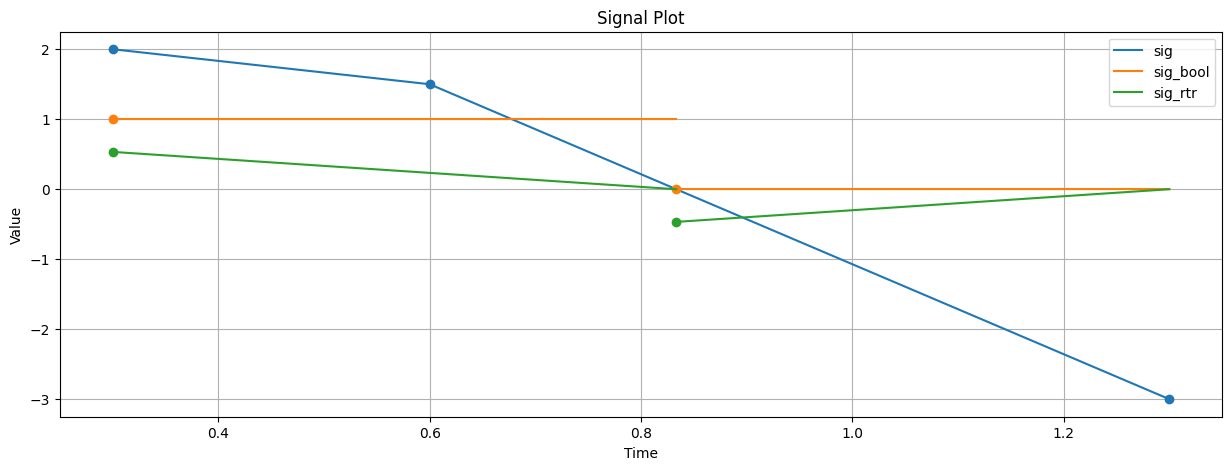

In [8]:
fig = plot_samples(sig, label='sig')
plot_samples(sig_bool, label='sig_bool', fig=fig)
#plot_samples(sig_ltr, label='sig_ltr', fig=fig)
plot_samples(sig_rtr, label='sig_rtr', fig=fig)

### Longer signals

<Axes: title={'center': 'Signal Plot'}, xlabel='Time', ylabel='Value'>

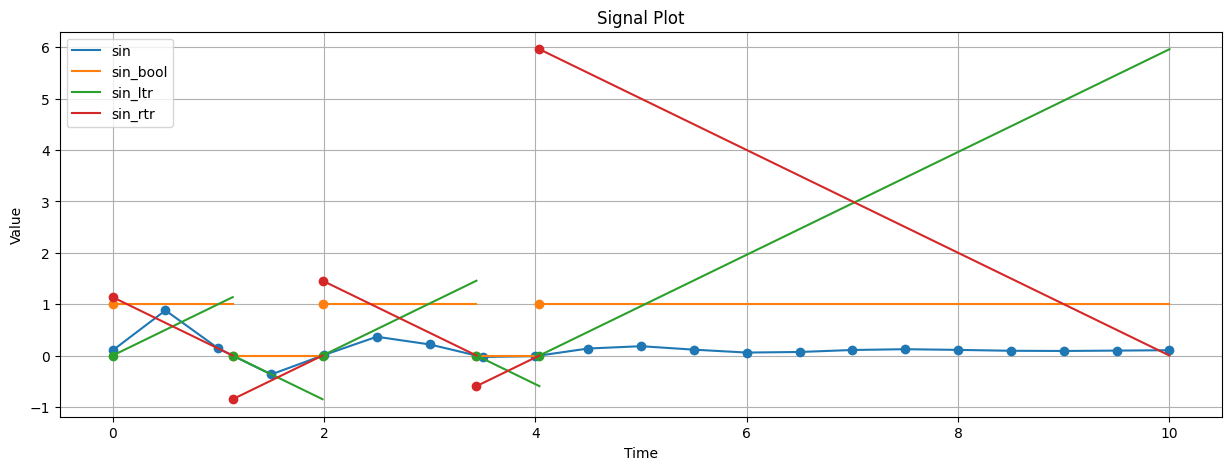

In [9]:
times = np.arange(0, 10.1, .5)
sin_val = np.sin(times*np.pi/2)
overshoot_val = np.sin(times*np.pi*np.exp(-times/50))*np.exp(-times/2)+.1
sig_sin = sr.Signal()
sig_overshoot = sr.Signal()

for i in range(0,len(times)):
    sig_sin.append_sample(times[i],sin_val[i])
    sig_overshoot.append_sample(times[i],overshoot_val[i])

sig_sin_bool= sr.Signal()
sig_sin_ltr = sr.Signal()
sig_sin_rtr = sr.Signal()

sig = sig_overshoot
sig_sin_bool.compute_boolean(sig)
sig_sin_ltr.compute_left_time_rob(sig)
sig_sin_rtr.compute_right_time_rob(sig)
fig = plot_samples(sig, label='sin')
plot_samples(sig_sin_bool, label='sin_bool', fig=fig)
plot_samples(sig_sin_ltr, label='sin_ltr', fig=fig)
plot_samples(sig_sin_rtr, label='sin_rtr', fig=fig)



In [10]:
for s in sig_sin_bool.get_samples_list():
    s.print_sample()


Time 0.00000 Value 1.00000 Derivative 0.00000
Time 1.13621 Value 0.00000 Derivative 0.00000
Time 1.98640 Value 1.00000 Derivative 0.00000
Time 3.44284 Value 0.00000 Derivative 0.00000
Time 4.03834 Value 1.00000 Derivative 0.00000


# Drivers

The following determines globally whether we use space, left time or right time robustnes.

In [2]:
sr.Signal().set_semantics('LEFT_TIME') 
#sr.Signal().set_semantics('RIGHT_TIME') 
#sr.Signal().set_semantics('SPACE') 


In [3]:
print(sr.Signal().get_semantics())


LEFT_TIME


We instantiate an STLDriver object. This object is the main interface to the library. 

In [4]:
monitor = stlrom.STLDriver()

We need to declare signals, parameters (optional), and formulas. For this we can use the `parse_string()` method. 

In [5]:
monitor.parse_string("signal x, y")       # declaring signals named 'x' and 'y'
monitor.parse_string("param p=0.2, tau=5") # declaring parameters named 'p' and 'q'

True

Let's declare formulas. 

In [6]:
monitor.parse_string("mu_x := x[t] > 0 ") # a atomic proposition
monitor.parse_string("mu_y := y[t] < p ") # another atomic proposition
monitor.parse_string("mu := mu_x and mu_y") # a compound proposition
monitor.parse_string("phi := ev_[0, tau] mu") # a temporal proposition
monitor.disp()


Assigned formulas:
-------------------
mu:
x[t] > 0 and y[t] < p
mu_x:
x[t] > 0
mu_y:
y[t] < p
phi:
ev_[0,tau] (x[t] > 0 and y[t] < p) 

Default Parameters:
---------------------
p=0.2
tau=5

Trace tests:
---------------




We can now add data. We do it by adding time valued samples of the form [t, x, y]. Be careful to respect the order of signals declaration.

In [7]:
monitor.add_sample([0, 2., 3.])     # at time 0, x=2, y=3
monitor.add_sample([0.5, -1., -4.]) # at time 0.5, x=-1, y=-4
monitor.add_sample([3., 3., -5.])    # etc.     
print(monitor.data)

[[0.0, 2.0, 3.0], [0.5, -1.0, -4.0], [3.0, 3.0, -5.0]]


We are now ready to evaluate formulas. For this we use the get_online_rob() method. 

In [8]:
rob_phi  = monitor.get_online_rob("phi")
print("rob_phi = ", rob_phi)


rob_phi =  [1.87500000000001, 1.87500000000001, 10000.0]
